# Определение возраста человека по фотографии

Цель: обучить нейросеть определять возраст человека по фотографии.

Метрика: MAE должна быть ниже 8

Датасет: [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/)

## Импорты

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import copy
import gc
import time
from sklearn.metrics import mean_absolute_error

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models
img_size = 350 #224
img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

import timm

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'

import warnings
warnings.filterwarnings("ignore")

Фиксируем рандом.

In [2]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

random_seed = 2077
seed_everything(random_seed)

В windows не работает параметр num_workers, поэтому сразу пропишем его.

In [3]:
if 'nt' not in os.name:
    num_workers = 8
else:
    num_workers = 1
print('num_workers =', num_workers)

num_workers = 8


Важная функция для многократных запусков при отладке - очистка видеопамяти.

In [4]:
def clear_GPU():
    gc.collect()
    torch.cuda.empty_cache()

Выбираем GPU.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Исследовательский анализ данных

Для анализа будем использовать традиционные инструменты.

Загрузим всю информацию о файлах в датафрейм.

Из исходных данных оставим только реальный возраст (как это сделано в датасете, предоставленном Яндексом).

Напишем функции для анализа всех трех составляющих датасета: трейн, валид и тест.

In [6]:
def get_df(mode='train'):
    print('reading files from ' + mode)
    df_labels = pd.read_csv('./data/gt_avg_'+mode+'.csv', index_col=0)
    file_list = []
    file_name_list = []
    for dirpath, dirnames, filenames in os.walk('./data/'+mode+'/'):
        files = [os.path.join(dirpath, file) for file in filenames if '_face' in os.path.join(dirpath, file)]
        full_names = [os.path.join(file) for file in filenames if '_face' in os.path.join(dirpath, file)]
        filenames = [os.path.join(file).replace('_face.jpg', '') for file in filenames if '_face' in os.path.join(dirpath, file)]

    files_df = pd.DataFrame(data=files, index=filenames, columns=['file'])
    files_df['file_short'] = pd.Series(data=full_names, index=filenames)
    df = df_labels.join(files_df, how='inner')
    df = df[['real_age', 'file', 'file_short']]

    df.info()
    display(df.head(3))
    return df

df_train = get_df()
print('\n------------------\n')
df_val = get_df('valid')
print('\n------------------\n')
df_test = get_df('test')

reading files from train
<class 'pandas.core.frame.DataFrame'>
Index: 4113 entries, 000000.jpg to 004112.jpg
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   real_age    4113 non-null   int64 
 1   file        4113 non-null   object
 2   file_short  4113 non-null   object
dtypes: int64(1), object(2)
memory usage: 128.5+ KB


real_age                              file           file_short
000000.jpg         4  ./data/train/000000.jpg_face.jpg  000000.jpg_face.jpg
000001.jpg        18  ./data/train/000001.jpg_face.jpg  000001.jpg_face.jpg
000002.jpg        80  ./data/train/000002.jpg_face.jpg  000002.jpg_face.jpg


------------------

reading files from valid
<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 004113.jpg to 005612.jpg
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   real_age    1500 non-null   int64 
 1   file        1500 non-null   object
 2   file_short  1500 non-null   object
dtypes: int64(1), object(2)
memory usage: 46.9+ KB


real_age                              file           file_short
004113.jpg        29  ./data/valid/004113.jpg_face.jpg  004113.jpg_face.jpg
004114.jpg        25  ./data/valid/004114.jpg_face.jpg  004114.jpg_face.jpg
004115.jpg        37  ./data/valid/004115.jpg_face.jpg  004115.jpg_face.jpg


------------------

reading files from test
<class 'pandas.core.frame.DataFrame'>
Index: 1978 entries, 005613.jpg to 007612.jpg
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   real_age    1978 non-null   int64 
 1   file        1978 non-null   object
 2   file_short  1978 non-null   object
dtypes: int64(1), object(2)
memory usage: 126.4+ KB


real_age                             file           file_short
file_name                                                                 
005613.jpg        19  ./data/test/005613.jpg_face.jpg  005613.jpg_face.jpg
005614.jpg        76  ./data/test/005614.jpg_face.jpg  005614.jpg_face.jpg
005615.jpg        40  ./data/test/005615.jpg_face.jpg  005615.jpg_face.jpg

Пропусков нет, реальный возраст - целые значения.

Считаем размеры всех изображений для анализа.

In [7]:
def get_im_size(df):
    h, w, c = [], [], []

    for i in tqdm(df.index):
        filename = df.loc[i, 'file']
        img = Image.open(filename)
        img = np.array(img)
        h.append(img.shape[0])
        w.append(img.shape[1])
        c.append(img.shape[2])

    df['h'] = np.array(h)
    df['w'] = np.array(w)
    df['c'] = np.array(c)
    
    return df

df_train = get_im_size(df_train)
df_val = get_im_size(df_val)
df_test = get_im_size(df_test)

100%|██████████| 1978/1978 [00:05<00:00, 353.86it/s]


Посмотрим на возраст в обучающей и валидационной выборках. Тестовую не трогаем - этих данных у нас как бы нет.

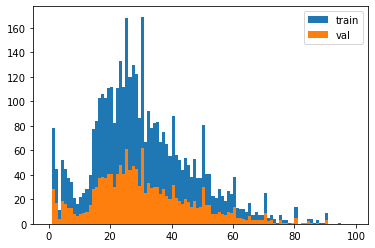

In [8]:
for df, mode in zip([df_train, df_val], ['train', 'val']):
    tmp = df['real_age']
    m1 = tmp.min()
    m2 = tmp.max()
    plt.hist(tmp, bins=np.arange(0,100), label=mode)
plt.legend();

Видим, что на обучающей и валидационной выборках возраст распределен одинаково.

Удостоверимся еще, что везде по 3 цвета.

In [9]:
display(pd.DataFrame(
    [pd.Series(df_train['c'].describe()),
     pd.Series(df_val['c'].describe()),
     pd.Series(df_test['c'].describe())
    ]))

count  mean  std  min  25%  50%  75%  max
c  4113.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
c  1500.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
c  1978.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0

Посмотрим на размеры картинок.

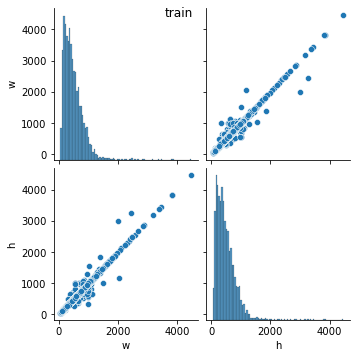

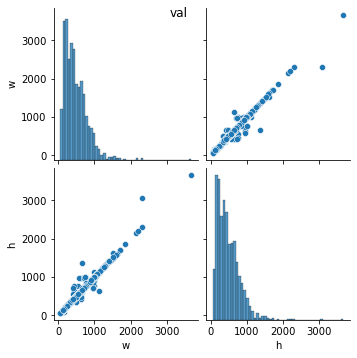

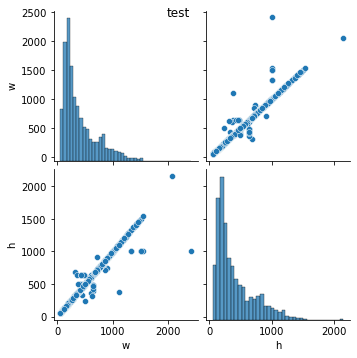

In [10]:
for df, mode in zip([df_train, df_val, df_test], ['train', 'val', 'test']):
    g = sns.pairplot(df[['w', 'h']])
    g.fig.suptitle(mode)
    plt.show()

Интересно, что в датасете есть просто огромные картинки. Кроме того, большая часть датасета - это квадратные изображения (диагональная линия на графиках).

### Визуальный анализ

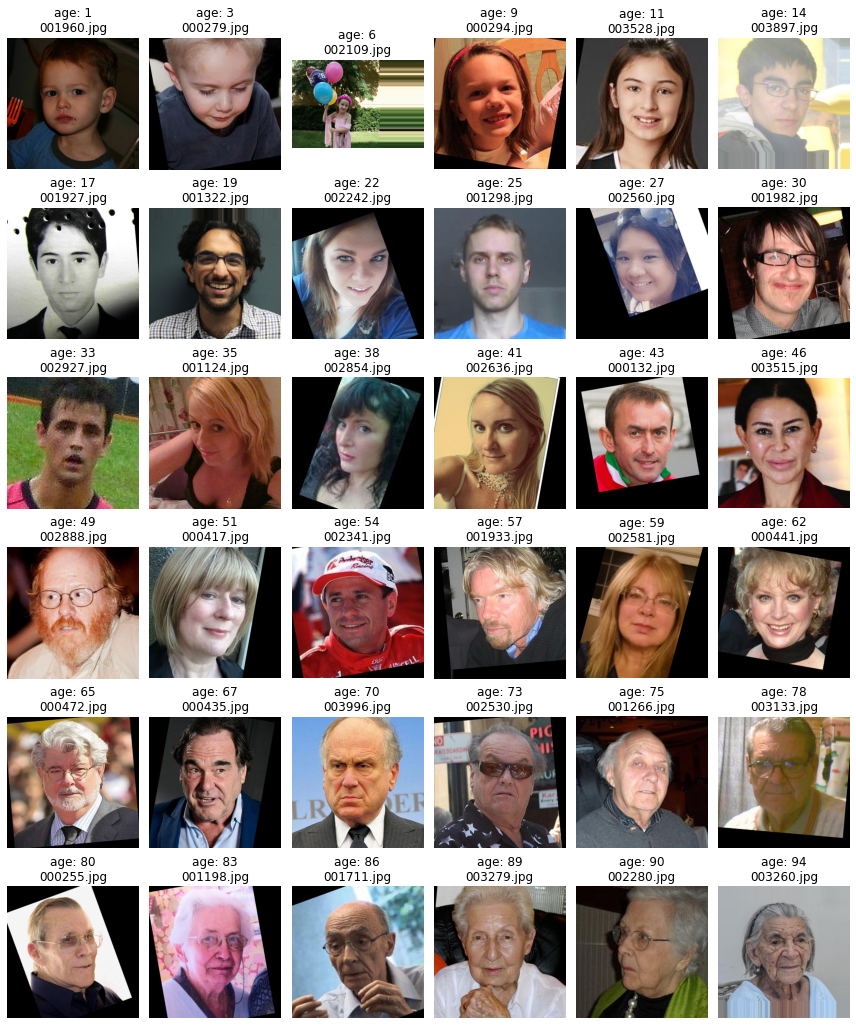

In [11]:
def show_images(df):
    m1 = df['real_age'].min()
    m2 = df['real_age'].max() - 3
    cols = 6
    rows = 6
    size = 2
    fig = plt.figure(figsize=(cols*size, rows*size*1.2))    
    for k in range(cols*rows):
        target_age = m1 + (m2-m1)/(cols*rows)*k
        target_age = int(target_age)
        tmp = df.copy()
        tmp['diff'] = np.abs(tmp['real_age'] - target_age)
        for i in range(4):
            if len(tmp[tmp['diff'] <= i]) > 0:
                tmp = tmp[tmp['diff'] <= i]
                break
        i = np.random.choice(tmp.index)
        filename = df['file'].loc[i]
        age = df['real_age'].loc[i]
        plt.subplot(rows, cols, k+1)
        img = Image.open(filename)
        plt.imshow(img)
        plt.title('age: ' + str(age) + '\n' + i)
        plt.axis('off')
    fig.tight_layout()
    plt.show()
show_images(df_train)

- на фото люди смотрят не только вперед, но и в сторону
- на некоторых фото голова немного наклонена
- на всех фото лицо занимает примерно 1/3 размера по горизонали
- на некоторых фотографиях лицо очень плохо видно (освещение, угол обзора)

- (по результатам длительного анализа) на некоторых фотографиях лицо человека вообще не видно

## Подготовка загрузчиков данных

Напишем универсальный датасет, который будет на вход принимать датафрейм и опционально - оператор трансформирования.

Все картинки будут приводиться к одному размеру с сохранением отношения сторон.

In [12]:
class FaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.basic_transform = A.Compose(
            [
                A.LongestMaxSize(max_size=img_size),
                A.PadIfNeeded(min_height=img_size, 
                              min_width=img_size, 
                              border_mode=0),
                A.Normalize(mean=img_mean, std=img_std),
                ToTensorV2(),
            ]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_filepath = self.df['file'].iloc[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        age = self.df['real_age'].iloc[idx]
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
            
        image = self.basic_transform(image=image)['image']
        
        return image.float(), age

Теперь самое интересное - аугментация тренировочного сета. Попробуем сделать сильную аугментацию.

In [13]:
color_shift = 10 # default 20
gamma_limit = (30,60)
blur_limit = 3

train_transform = A.Compose([
    A.HorizontalFlip(),
    A.ShiftScaleRotate(shift_limit=0.3, 
                       scale_limit=0.3, 
                       rotate_limit=15, 
                       border_mode=0, value=0),
    A.RGBShift(r_shift_limit=color_shift, 
               g_shift_limit=color_shift, 
               b_shift_limit=color_shift),
    A.HueSaturationValue(),
    A.OneOf([
        A.Sharpen(),
        A.AdvancedBlur(blur_limit=(1, blur_limit)),
    ], p=0.5),
    A.OneOf([
        A.ISONoise(),
        A.MultiplicativeNoise(),
        A.GaussNoise()
    ], p=0.5),
    A.PixelDropout(p=0.33),
    A.OpticalDistortion(),
    A.ToSepia(p=0.1),
])

Создаем все три даталоадера.

In [14]:
batch_size = 12

train_ds = FaceDataset(df_train, train_transform)
val_ds = FaceDataset(df_val)
test_ds = FaceDataset(df_test)

train_loader = DataLoader(train_ds,
                     batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_loader = DataLoader(val_ds,
                     batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_loader = DataLoader(test_ds,
                     batch_size=batch_size, shuffle=False, num_workers=num_workers)

Посмотрим на то, что выдает наш даталоадер.

In [15]:
for i in train_loader:
    batch = i
    break
batch[0].shape, batch[1].shape

(torch.Size([12, 3, 350, 350]), torch.Size([12]))

А теперь посмотрим глазами на аугментацию.

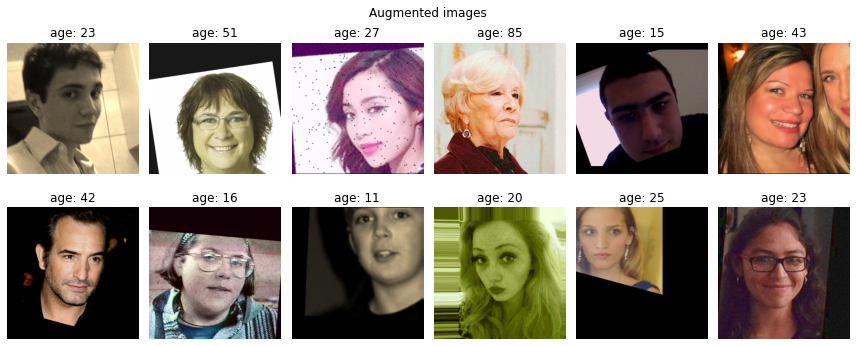

In [16]:
cols = 6
rows = 5
size = 2

for i in train_loader:
    batch = i
    break
batch[0] = batch[0].permute(0,2,3,1).numpy()
batch[1] = batch[1].numpy()
fig = plt.figure(figsize=(cols*size, rows*size*1.2))    
for k in range(min(cols*rows, batch[1].shape[0])):
    age = batch[1][k]
    img = batch[0][k] * img_std + img_mean
    img = np.clip(img, 0, 1)
    plt.subplot(rows, cols, k+1)
    plt.imshow(img)
    plt.title('age: ' + str(age))
    plt.axis('off')
plt.suptitle('Augmented images')
fig.tight_layout()
plt.show()

Итого: добавили разнообразия картинкам, не потеряв основных качеств - глазом хорошо видно, что на картинке.

## Архитектура модели

Будем использовать efficientnet как самую быструю из точных / точную из быстрых. Особо интересно попробовать V2. Посмотрим, какие уже есть в библиотеке timm.

In [17]:
timm.list_models('*efficientnet*v2*')

['efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl',
 'gc_efficientnetv2_rw_t',
 'tf_efficientnetv2_b0',
 'tf_efficientnetv2_b1',
 'tf_efficientnetv2_b2',
 'tf_efficientnetv2_b3',
 'tf_efficientnetv2_l',
 'tf_efficientnetv2_l_in21ft1k',
 'tf_efficientnetv2_l_in21k',
 'tf_efficientnetv2_m',
 'tf_efficientnetv2_m_in21ft1k',
 'tf_efficientnetv2_m_in21k',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_s_in21ft1k',
 'tf_efficientnetv2_s_in21k',
 'tf_efficientnetv2_xl_in21ft1k',
 'tf_efficientnetv2_xl_in21k']

Создаем модель на основе V2 размера M. Тут же сразу указываем, что модель будет иметь один выходной нейрон.

In [18]:
efficientnet = timm.create_model('efficientnetv2_rw_m', pretrained=True, num_classes=1)
efficientnet.eval();

Проверим, что все работает - сделаем случайны батч и скормим его сети.

In [19]:
b = torch.randn(4,3,224,224)
b.shape

torch.Size([4, 3, 224, 224])

In [20]:
efficientnet(b)

tensor([[0.3520],
        [0.3229],
        [0.3356],
        [0.2090]], grad_fn=<AddmmBackward0>)

А работает ли эта сеть с нестандартными размерами входа?

In [21]:
b = torch.randn(4,3,150,400)
efficientnet(b)

tensor([[-0.3892],
        [-0.4522],
        [-0.4023],
        [-0.5444]], grad_fn=<AddmmBackward0>)

Похоже, работает.

Завернем это в функцию.

## Обучение сети

Нам потребуется множество вспомогательных функций.

Построение кривых обучения по словарю-истории:

In [22]:
def plot_train_curves(history, name='', best_min=True):
    train_loss, val_loss, train_metr, val_metr, lr = history['train_loss'], history['val_loss'], history['train_metr'], history['val_metr'], history['lr'], 
    fig = plt.figure(figsize=(6,8))
    fig.patch.set_facecolor('xkcd:white')
    plt.subplot(3,1,1)
    points = np.array(train_loss + val_loss, dtype=float)
    points = points[~np.isnan(points)]
    points = points[np.isfinite(points)]
    p = 0.08
    q1, q2 = np.nanquantile(points, p), np.nanquantile(points, 1-p)
    iqr = q2 - q1
    lim1 = max(np.nanmin(points) - iqr * 0.06, q1 - iqr * 1.2)
    lim2 = min(np.nanmax(points) + iqr * 0.06, q2 + iqr * 1.2)
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend()
    plt.ylim(lim1, lim2)
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(3,1,2)
    plt.plot(train_metr, label="train_metr")
    plt.plot(val_metr, label="val_metr")
    if best_min:
        my = np.array(val_metr).min()
        mx = np.argmin(np.array(val_metr))
    else:
        my = np.array(val_metr).max()
        mx = np.argmax(np.array(val_metr))
    plt.scatter(x=[mx], y=[my], c='red', s=80)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("metric")

    plt.subplot(3,1,3)
    plt.plot(lr, label="LR")
    plt.xlabel("epochs")
    plt.ylabel("LR")
    plt.yscale('log')
    
    if len(name) > 0:
        plt.suptitle(name)
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.savefig(name+'.png')
    plt.show()

Одна эпоха обучения или валидации:

In [23]:
def single_epoch(model, optimizer, loss_fn, data_loader, metric, mode='val'):
    
    torch.set_grad_enabled(mode == 'train')
    if mode == 'train':
        model.train()
    else:
        model.eval()
    
    avg_loss = 0
    model.train()  # train mode
    pics = [] # real data
    gts = [] # reconstructed data
    preds = []
    losses = []
    for X_batch, Y_batch in data_loader:
        
        pics.append(X_batch.detach().numpy())
        gts.append(Y_batch.detach().numpy().flatten())
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        if mode == 'train': optimizer.zero_grad()

        pred = model(X_batch)
        preds.append(pred.cpu().detach().numpy().flatten())
        loss = loss_fn(pred.flatten(), Y_batch.flatten().to(torch.float32))
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            
        losses.append(loss.cpu().detach().item())

    pics = np.concatenate(pics, axis=0)
    gts = np.concatenate(gts, axis=0)
    preds = np.concatenate(preds, axis=0)

    epoch_loss = np.array(losses).mean()
    epoch_metr = metric(preds, gts).mean()
    
    torch.set_grad_enabled(True)
    model.eval()
    
    return dict(pics=pics, gts=gts, preds=preds, loss=epoch_loss, metr=epoch_metr)

Показ нескольких валидационных картинок и их предсказаний (в конце каждой эпохи)

In [24]:
def show_val_pics(pics, gts, preds, name='', history=None,
                  epoch=None, epochs=None, best_metr=None, num=12):
    pics = pics.transpose(0,2,3,1)
    idx = np.random.choice(pics.shape[0], num, replace=False)
    fig = plt.figure(figsize=(10,5))
    for k in range(num):
        n = idx[k]
        img = pics[n]
        img = img * img_std + img_mean
        img = np.clip(img, 0, 1)
        plt.subplot(2, num//2, k+1)
        plt.imshow(img, cmap='gray')
        gt, pred = gts[n], preds[n]
        plt.title(f'GT: {gt},\nPred: {pred:.1f}')
        plt.axis('off')

    if history is not None:
        train_m = history['train_metr'][-1]
        val_m = history['val_metr'][-1]
        s = f'{name}   Epoch: {epoch+1}/{epochs}   train metric: {train_m:.4f}   valid metric: {val_m:.4f}   [best metric {best_metr:.4f}]'
        plt.suptitle(s)        
        
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.show()

Обучающая функция.

In [25]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val, 
             metric, best_min_metr=True, scheduler=None, 
             plots=True, set_best_params=True, name=''):
    
    # set default metric as "the best"
    val_res = single_epoch(model, optimizer, loss_fn, data_val, metric, mode='val')
    best_metr = val_res['metr']
    best_loss = val_res['loss']
    print(f'before training: val_loss: {best_loss:.2f}    val_metr: {best_metr:.2f}')
    best_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    # empty training history
    history = dict(
        train_loss = [],
        val_loss = [],
        train_metr = [],
        val_metr = [],
        lr = []
    )

    for epoch in range(epochs):
            
        print(f'Epoch {epoch+1}/{epochs}, best = {best_epoch}', end='    ')
        history['lr'].append(optimizer.param_groups[0]["lr"])
        
        # training
        train_res = single_epoch(model, optimizer, loss_fn, data_tr, metric, mode='train')
        history['train_loss'].append(train_res['loss'])
        history['train_metr'].append(train_res['metr'])

        # validation
        val_res = single_epoch(model, optimizer, loss_fn, data_val, metric, mode='val')
        pics = val_res['pics']
        gts = val_res['gts']
        preds = val_res['preds']
        history['val_loss'].append(val_res['loss'])
        history['val_metr'].append(val_res['metr'])
        
        # print epoch result
        tr_loss = history['train_loss'][-1]
        tr_metr = history['train_metr'][-1]
        val_loss = history['val_loss'][-1]
        val_metr = history['val_metr'][-1]
        
        if plots and epoch > 1:
            clear_output(wait=True)
        
        print(f'tr_loss: {tr_loss:.2f}  tr_metr: {tr_metr:.2f}' + \
              f'   val_loss: {val_loss:.2f}  val_metr: {val_metr:.2f}')
        
        # if best epoch: save weights
        if (history['val_metr'][-1] <= best_metr) * (-1+2*int(best_min_metr)):
            print('new best val metric!')
            best_epoch = epoch + 1
            best_metr = history['val_metr'][-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            model_file_name = './models/model_trained.pt'
            os.remove(model_file_name)
            torch.save(model, model_file_name)

        # scheduler step (if needed)
        if scheduler != None: scheduler.step(history['val_loss'][-1])

        # visualize
        if plots:
            show_val_pics(pics, gts, preds, name, history, epoch, epochs, best_metr)
            if epoch > 1:
                plot_train_curves(history, name)
    
    # load best weigts if needed
    if set_best_params:
        model.load_state_dict(best_model_wts)
        print(f'Weights loaded from best epoch {best_epoch}, metric = {best_metr:.2f}')
            
    return(history)

Само обучение. Здесь мы сначала учим только последний слой сети (регрессионный), а потом уже "размораживаем" всю сеть.

tr_loss: 15.28  tr_metr: 2.92   val_loss: 57.97  val_metr: 5.35
new best val metric!


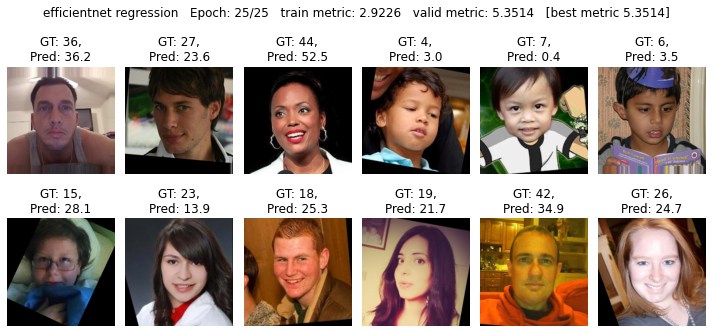

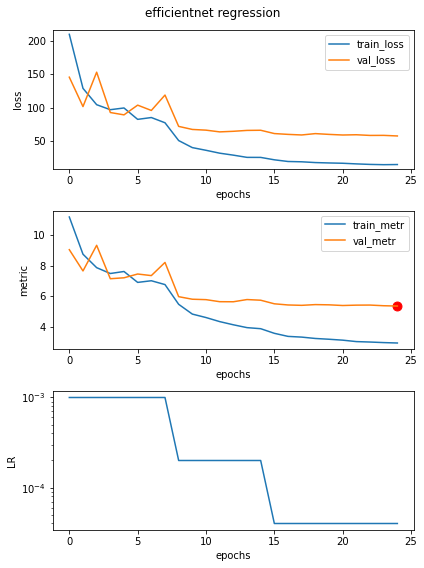

Weights loaded from best epoch 25, metric = 5.35
CPU times: user 36min 7s, sys: 7min 17s, total: 43min 24s
Wall time: 43min 54s


In [26]:
%%time
clear_GPU()
model = timm.create_model('efficientnetv2_rw_s', pretrained=True, num_classes=1)
model.to(device)
criterion = nn.MSELoss()
metr = lambda x,y: mean_absolute_error(x, y)
lr = 1e-3
weight_decay = 1e-3
epochs = 25
opt_type = torch.optim.AdamW

# train only last layer
optimizer = opt_type(model.classifier.parameters(), lr=lr, weight_decay=weight_decay)

h = train(model=model, optimizer=optimizer, loss_fn=criterion, 
             epochs=1, data_tr=train_loader, data_val=val_loader, metric=metr, 
             scheduler=None, name='efficientnet regression pre-train')

# train full network
optimizer = opt_type(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

h = train(model=model, optimizer=optimizer, loss_fn=criterion, 
             epochs=epochs, data_tr=train_loader, data_val=val_loader, metric=metr, 
             scheduler=scheduler, name='efficientnet regression')

Модель обучилась, на валидации все хорошо. Есть небольшое переобучение, но для нейросетей это нормально.

## Анализ обученной модели

Запустим нашу функцию валидации на тестовом датасете.

In [27]:
model = torch.load('./models/model_trained.pt')
model.to(device)
model.eval();

In [28]:
h = single_epoch(model=model, optimizer=None, loss_fn=criterion, 
                 data_loader=test_loader, metric=metr, mode='val')

Посмотрим на метрику (и лосс).

In [29]:
m, l = h['metr'], h['loss']
print(f'Test MAE = {m:.2f}')
print(f'Test LOSS(MSE) = {l:.2f}')

Test MAE = 6.49
Test LOSS(MSE) = 84.94


Результат кажется не таким уж хорошим в сравнении с запуском кода на keras на тренажере (MAE 6.1381, см. ниже). Но надо учитывать, что в тренажере весь датасет был разбит на обучающий и валидационный, а тестового не было. Таким образом, в тренажере обучение велось на большем количестве фотографий.

А теперь глазами оценим масштаб проблем.

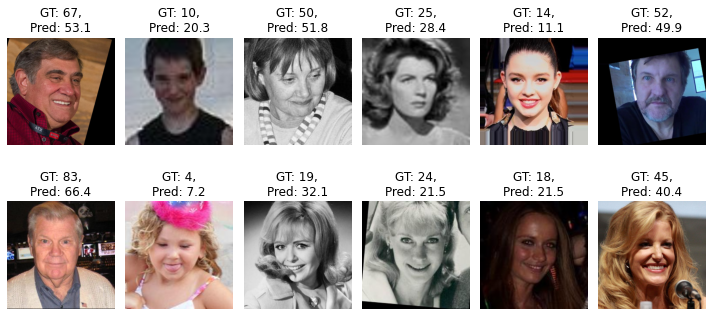

In [30]:
show_val_pics(h['pics'], h['gts'], h['preds'])

### Анализ ошибок

Посмотрим, на каких картинках тестового датасета модель ошибается сильнее всего.

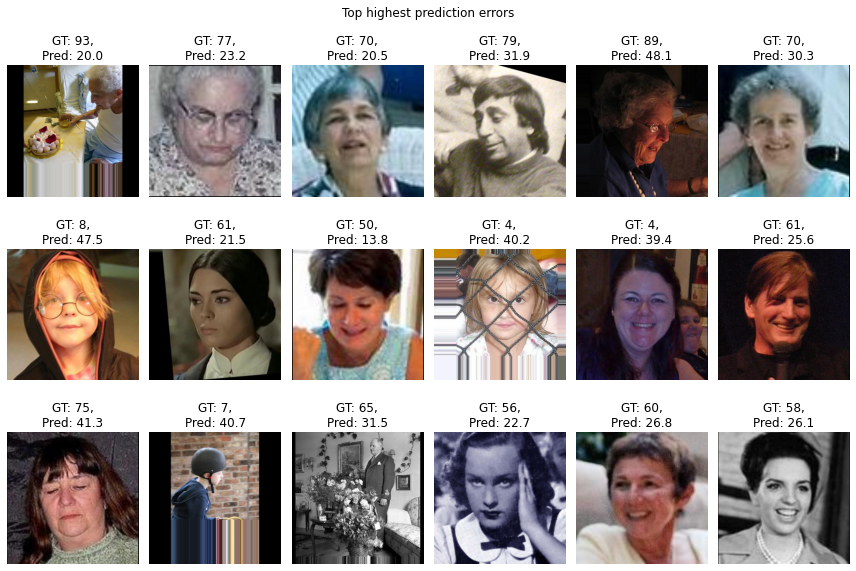

In [31]:
cols = 6
rows = 3
size = 2

err = pd.DataFrame([h['gts'], h['preds']], index=['gts', 'preds']).T
err['err'] = np.abs(err['gts'] - err['preds'])
err = err.sort_values('err', ascending=False)
err = err.head(rows*cols)
idx = err.index

fig = plt.figure(figsize=(cols*size, rows*size*1.4))    

for r in range(rows):
    for c in range(cols):
        i = r * cols + c
        plt.subplot(rows, cols, i+1)
        
        i = idx[i]
        img = h['pics'][i]
        img = img.transpose(1,2,0)
        img = img * img_std + img_mean
        img = np.clip(img, 0, 1)
        gt = h['gts'][i]
        pred = h['preds'][i]
        plt.imshow(img)
        plt.title(f'GT: {gt},\nPred: {pred:.1f}')
        plt.axis('off')
        
fig.patch.set_facecolor('xkcd:white')
plt.suptitle('Top highest prediction errors')
fig.tight_layout()
plt.show()

Несколько фото здесь вообще не позволяют определить возраст (лицо слишком маленькое).
На нескольких - слишком сильная пикселизация.
На некоторых - лицо частично закрыто.

А на некоторых я бы доверял предсказаниям модели больше, чем GT ;) 

### Индивидуальный инференс

Ну раз уж модель есть, давайте попробуем ее на фото, не входящих в датасет! Напишем функцию для инференса единственного изображения.

In [32]:
def predict(model, file):
    tmp_df = pd.DataFrame([file, None], index=['file', 'real_age']).T
    ds = FaceDataset(tmp_df)
    img = ds[0][0].permute(1,2,0).numpy()
    img = img * img_std + img_mean
    img = np.clip(img, 0, 1)
    in_tensor = ds[0][0].unsqueeze(0)
    in_tensor = in_tensor.to(device)
    model.eval()
    with torch.no_grad():
        res = model(in_tensor)
    res = res.cpu().item()
    res
    
    name = file.split('/')[-1]
    name = name.rsplit('.')
    name = './predicted/' + name[0] + '_pred.' + name[1]

    plt.imshow(img)
    plt.title(f'Predicted age: {res:.1f}')
    plt.axis('off')
    plt.savefig(name, bbox_inches='tight')
    plt.show()

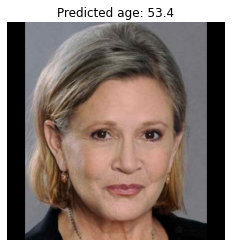

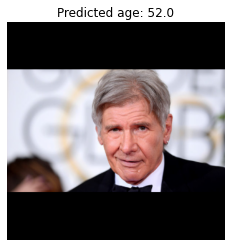

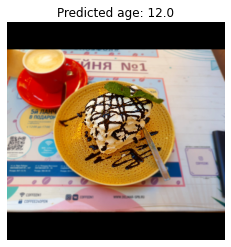

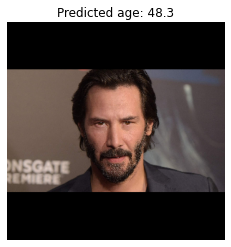

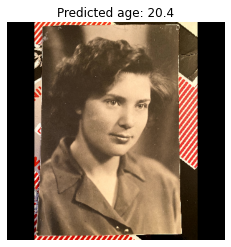

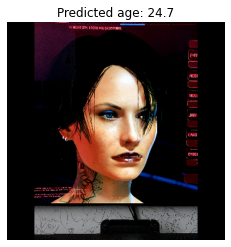

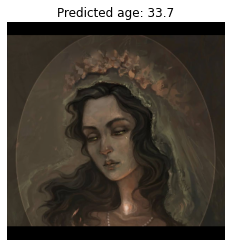

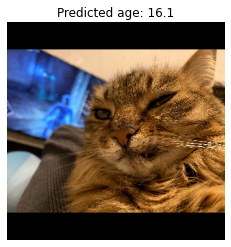

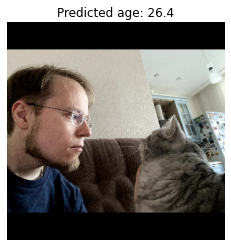

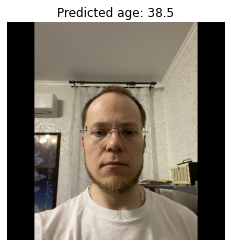

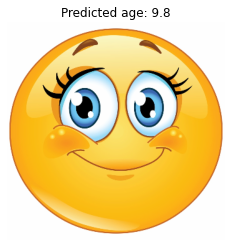

In [33]:
for dirpath, dirnames, filenames in os.walk('./my_photo'):
    files = [os.path.join(dirpath, file) for file in filenames]
    
try: os.mkdir('predicted')
except: pass
    
for file in files:
    predict(model, file)

Ну в целом работает адекватно.

Основная проблема - модель не проверяет, есть ли на картинке вообще лицо.

## Keras

Коды для обучения модели в keras на тренажере Яндекса:

In [34]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import datetime
import tensorflow
import pandas as pd

2022-05-22 15:14:04.982992: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [35]:
def load_data(path, mode='training'):

    if mode != "training": mode = "validation"
    print('loading datagen for', mode, 'path =', path, datetime.datetime.now())
    
    validation_split = 0.2
    batch_size = 32
    target_size = (224, 224)
    max_rotation_range = None
    preprocessing_function = None
    seed = 2077
    
    print('loading labels for', mode)
    labels = pd.read_csv(path+'/labels.csv')
    
    print('creating ImageDataGenerator for', mode)
    datagen = ImageDataGenerator(
        validation_split=validation_split,
        rescale=1./255,
        horizontal_flip=True if mode == 'training' else False,
        rotation_range=max_rotation_range if mode == 'training' else None,
        preprocessing_function=preprocessing_function if mode == 'training' else 0,
        fill_mode='constant',
        cval=0,
    )
    
    print('creating Flow for', mode)
    gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        subset=mode,
        seed=seed)
    
    print('returning flow for', mode, datetime.datetime.now())
    return gen_flow

In [36]:
def load_train(path):
    random_seed = 2077
    print('setting random seed', random_seed)
    tensorflow.random.set_seed(random_seed)
        
    return load_data(path, mode='training')

In [37]:
def load_test(path):
    return load_data(path, mode='validation') 

In [38]:
def create_model(input_shape):
    print('start model creation', datetime.datetime.now())
    print('input_shape =', input_shape)
    
    learning_rate = 3e-4
    print('learning_rate =', learning_rate)
    
    print('loading backbone')
    backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1)) 
    
    opt = Adam(learning_rate=learning_rate)
    
    print('compiling model')
    
    model.compile(optimizer=opt, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    print(model.summary())
    
    print('finished model creation', datetime.datetime.now())

    return model

In [39]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    
    print('started training', datetime.datetime.now())
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    print('finished training', datetime.datetime.now())
    return model

Выдача:

```
setting random seed 2077
loading datagen for training path = /datasets/faces/ 2022-05-19 07:16:17.038182
loading labels for training
creating ImageDataGenerator for training
creating Flow for training
Found 6073 validated image filenames.
returning flow for training 2022-05-19 07:16:17.477968
loading datagen for validation path = /datasets/faces/ 2022-05-19 07:16:17.478045
loading labels for validation
creating ImageDataGenerator for validation
creating Flow for validation
Found 1518 validated image filenames.
returning flow for validation 2022-05-19 07:16:17.526420
start model creation 2022-05-19 07:16:17.526562
input_shape = (224, 224, 3)
learning_rate = 0.0003
loading backbone
2022-05-19 07:16:17.693238: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-19 07:16:18.392306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
```
...
```
2022-05-19 07:16:25.520812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
compiling model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
finished model creation 2022-05-19 07:16:52.988514
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
started training 2022-05-19 07:16:52.988565
Train for 190 steps, validate for 48 steps
Epoch 1/20
2022-05-19 07:17:00.739211: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-19 07:17:04.472210: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 120s - loss: 215.2659 - mean_absolute_error: 11.1136 - val_loss: 1111.8225 - val_mean_absolute_error: 28.7476
Epoch 2/20
190/190 - 37s - loss: 112.6556 - mean_absolute_error: 8.2065 - val_loss: 573.7647 - val_mean_absolute_error: 18.6803
Epoch 3/20
190/190 - 37s - loss: 80.6338 - mean_absolute_error: 7.0008 - val_loss: 496.1387 - val_mean_absolute_error: 16.8820
Epoch 4/20
190/190 - 37s - loss: 58.9358 - mean_absolute_error: 6.0408 - val_loss: 175.1919 - val_mean_absolute_error: 9.7567
Epoch 5/20
190/190 - 37s - loss: 47.2390 - mean_absolute_error: 5.3533 - val_loss: 90.9452 - val_mean_absolute_error: 7.2129
Epoch 6/20
190/190 - 37s - loss: 38.4645 - mean_absolute_error: 4.7355 - val_loss: 77.7132 - val_mean_absolute_error: 6.6351
Epoch 7/20
190/190 - 37s - loss: 32.1500 - mean_absolute_error: 4.3856 - val_loss: 85.2343 - val_mean_absolute_error: 6.9558
Epoch 8/20
190/190 - 37s - loss: 28.6227 - mean_absolute_error: 4.0980 - val_loss: 75.8702 - val_mean_absolute_error: 6.6735
Epoch 9/20
190/190 - 37s - loss: 25.0211 - mean_absolute_error: 3.8688 - val_loss: 72.3610 - val_mean_absolute_error: 6.4737
Epoch 10/20
190/190 - 37s - loss: 23.9442 - mean_absolute_error: 3.7892 - val_loss: 79.2101 - val_mean_absolute_error: 6.6247
Epoch 11/20
190/190 - 37s - loss: 20.9309 - mean_absolute_error: 3.5342 - val_loss: 74.4027 - val_mean_absolute_error: 6.7059
Epoch 12/20
190/190 - 37s - loss: 19.9522 - mean_absolute_error: 3.4723 - val_loss: 68.5248 - val_mean_absolute_error: 6.1450
Epoch 13/20
190/190 - 37s - loss: 17.6361 - mean_absolute_error: 3.2458 - val_loss: 72.9152 - val_mean_absolute_error: 6.4752
Epoch 14/20
190/190 - 37s - loss: 17.4863 - mean_absolute_error: 3.2297 - val_loss: 70.6481 - val_mean_absolute_error: 6.3454
Epoch 15/20
190/190 - 37s - loss: 15.5449 - mean_absolute_error: 3.0696 - val_loss: 74.2962 - val_mean_absolute_error: 6.6388
Epoch 16/20
190/190 - 37s - loss: 15.3315 - mean_absolute_error: 3.0000 - val_loss: 68.7499 - val_mean_absolute_error: 6.4012
Epoch 17/20
190/190 - 37s - loss: 14.6461 - mean_absolute_error: 2.9264 - val_loss: 66.3452 - val_mean_absolute_error: 6.2776
Epoch 18/20
190/190 - 37s - loss: 14.3443 - mean_absolute_error: 2.8932 - val_loss: 71.8946 - val_mean_absolute_error: 6.3617
Epoch 19/20
190/190 - 37s - loss: 14.1721 - mean_absolute_error: 2.9134 - val_loss: 73.6233 - val_mean_absolute_error: 6.4665
Epoch 20/20
190/190 - 37s - loss: 14.7855 - mean_absolute_error: 2.9221 - val_loss: 65.8297 - val_mean_absolute_error: 6.1381
finished training 2022-05-19 07:30:38.264869
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 7s - loss: 65.8297 - mean_absolute_error: 6.1381
Test MAE: 6.1381
```

Отметим, что в соответствии с инструкцией Яндекса в коде нет тестовой выборки: весь датасет разбит на обучающую и валидационную выборки. В результате обучающая выборка стала больше, а метрика (на валидации) лучше. Метрики на честном тесте здесь просто нету.

## Выводы

- обучена модель-регрессор на основе EfficientNet V2 S, предсказывающая возраст человека по фотографии его лица
- размер сети (версия S) выбран так, чтобы в видеопамять влезал батч более 10 изображений
- при обучении использованы аугментации из библиотеки albumentations. Это снизило скорость обучения, но повысило качество результата